In [43]:
#Data manipulation
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import pprint 

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Stats tests
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

#Machine Learning
from sklearn import set_config
set_config(display='diagram') #display pipeline in notebook
#Model Developoment
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, MultiLabelBinarizer, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
#Model Evaluation
from sklearn.metrics import mean_squared_error

### __Data Dictionary (DataFrame)__
This is the code for a data dictionary in pandas dataframe format.  Call `data_dict_df` any time in the notebook to pull it up.

This dataset is derived from [boardgamegeek.com](`https://www.boardgamegeek.com') (BGG).

In [4]:
data_dict = {
            'name' : {'data_type': 'str',  
                      'description': 'name of the game/expansion'},
            'rating_average' : {'data_type': 'float',  
                                'description': 'average user rating (more information [here]("https://boardgamegeek.com/wiki/page/ratings"))'},
            'year' : {'data_type': 'str',  
                      'description': 'year published'},
            'artists' : {'data_type': 'list',  
                         'description': 'game artists'},
            'categories' : {'data_type': 'list',  
                            'description': 'categories associated with game'},
            'designers' : {'data_type': 'list',  
                           'description': 'game designers'},
            'is_expansion' : {'data_type': 'bool',  
                              'description': 'whether the game is an expansion'},
            'expands' : {'data_type': 'list',  
                         'description': 'the core game(s) for which this is an expansion'},
            'expansion_ids' : {'data_type': 'list',  
                               'description': 'the expansions of this game'},
            'families' :  {'data_type': 'list',  
                           'description': 'groups/collections to which the game belongs'},
            'implementations' : {'data_type': 'list',  
                                 'description': 'games from which the current game stems (often referred to ask "re-skinned" games)'},
            'min_players' : {'data_type': 'int',  
                             'description': 'minimum number of players supported'},
            'max_players' : {'data_type': 'int',  
                             'description': 'maximum number of players supported'},
            'mechanics' : {'data_type': 'list',  
                           'description': 'mechanics employed by the game'},
            'min_age' : {'data_type': 'int',  
                         'description': 'minimum recommended age of player'},
            'playing_time' : {'data_type': 'int',  
                              'description': 'typical time (minutes) required to play'},
            'publishers' : {'data_type': 'list',  
                            'description': 'game publishers'},
            'ranks' : {'data_type': 'list of dicts',  
                       'description': 'rank of game among various categories'},
            'rating_average_weight' : {'data_type': 'float', 
                                       'description': '"Complexity" Rating how difficult a game is to understand. Lower rating (lighter weight) means easier." BGG uses a 5-point Weight scale (Light, Medium Light, Medium, Medium Heavy, Heavy)'},
            'rating_bayes_average' : {'data_type': 'float', 
                                      'description': 'bayesian average; a rating adjusted to account for games with few (but very high/low) ratings'},
            'rating_median'  : {'data_type': 'int', 
                                'description': 'median rating'},
            'rating_num_weights' : {'data_type': 'int', 
                                    'description': '???'},
            'rating_stddev'  : {'data_type': 'float',  
                                'description': 'standard deviation of user ratings'},
            'users_commented'  : {'data_type': 'int',  
                                  'description': 'number of users commented on game on BGG'},
            'users_owned'  : {'data_type': 'int',  
                              'description': 'number of users indicating that they own the game'},
            'users_rated' : {'data_type': 'int', 
                             'description': 'number of users that have rated the game on BGG'},
            'users_trading' :  {'data_type': 'int', 
                                'description': 'number of users interested in trading the game on BGG'},
            'users_wanting'  : {'data_type': 'int', 
                                'description': 'number of users indicating they want the game'},
            'users_wishing' : {'data_type': 'int', 
                               'description': 'number of users who have placed the game on a wishlist (on BGG)'}    
            }

data_dict_df = pd.DataFrame(data_dict).T

## __To Do__

* Consider creating own Bayesian average (as 622 are currently missing) - [walkthrough here]('https://stackoverflow.com/questions/54357300/bayesian-averaging-in-a-dataframe')
    * rating counts would presumably come from `users_rated`, or possibly retrieved/scraped from pages like [this]('https://boardgamegeek.com/boardgame/174430/gloomhaven/stats')?

## __Read in Data__

For a brief description of the dataset features see the data dictionary (above)

In [5]:
bgg_df = pd.read_json('bgg_data.json', orient='index')
bgg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3725 entries, 302809 to 274442
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   3725 non-null   object 
 1   rating_average         3725 non-null   float64
 2   year                   3725 non-null   int64  
 3   artists                3725 non-null   object 
 4   categories             3725 non-null   object 
 5   designers              3725 non-null   object 
 6   is_expansion           3725 non-null   bool   
 7   expands                3725 non-null   object 
 8   expansion_ids          3725 non-null   object 
 9   families               3725 non-null   object 
 10  implementations        3725 non-null   object 
 11  min_players            3725 non-null   int64  
 12  max_players            3725 non-null   int64  
 13  mechanics              3725 non-null   object 
 14  min_age                3725 non-null   int64  
 1

## **Cleaning & Exploratory Analysis**

Let's take a look at features we have to work with.

In [6]:
bgg_df.describe()

,rating_average,year,min_players,max_players,min_age,playing_time,rating_average_weight,rating_bayes_average,rating_median,rating_num_weights,rating_stddev,users_commented,users_owned,users_rated,users_trading,users_wanting,users_wishing
count,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.0,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000
mean,7.347246,2013.113826,1.791678,5.071141,10.857181,74.244564,1.947713,5.027354,0.0,86.058792,1.374540,391.181477,3613.595168,1897.366711,65.910336,102.743893,549.337718
std,0.974098,75.441201,0.760946,7.147332,3.650038,138.418420,1.160177,2.310146,0.0,346.492100,0.333089,1100.486381,8863.907574,6144.488088,154.466618,197.179283,1261.577777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.927180,2015.000000,1.000000,4.000000,10.000000,30.000000,1.231200,5.547200,0.0,1.000000,1.200330,23.000000,312.000000,53.000000,5.000000,11.000000,45.000000
50%,7.471410,2017.000000,2.000000,4.000000,12.000000,60.000000,2.009200,5.696460,0.0,6.000000,1.341340,72.000000,1016.000000,209.000000,19.000000,34.000000,140.000000
75%,7.941830,2019.000000,2.000000,6.000000,14.000000,90.000000,2.796600,6.177980,0.0,30.000000,1.521270,242.000000,3027.000000,947.000000,57.000000,98.000000,441.000000
max,10.000000,2021.000000,9.000000,100.000000,21.000000,6000.000000,5.000000,8.567880,0.0,7191.000000,4.500000,17885.000000,145103.000000,96453.000000,2410.000000,1958.000000,16299.000000


Because the `.describe()` method only works on numeric features, we'll have to dig a bit more to get a better understanding of those with non-numeric values.

In [7]:
#Get number of zeros in each column
(bgg_df == 0).sum(axis=0)

name                        0
rating_average             19
year                        5
artists                     0
categories                  0
designers                   0
is_expansion             2135
expands                     0
expansion_ids               0
families                    0
implementations             0
min_players                37
max_players                42
mechanics                   0
min_age                   228
playing_time              236
publishers                  0
ranks                       0
rating_average_weight     675
rating_bayes_average      622
rating_median            3725
rating_num_weights        675
rating_stddev              47
users_commented            31
users_owned                 5
users_rated                19
users_trading             244
users_wanting              96
users_wishing              10
dtype: int64

While there are many zero-values in about half of the features, some of the make sense and are of no concern (e.g. `is_expansion`, `users_commented`, `users_trading`, etc.), while others, such as the `rating_*`s features are a bit more concerning.  Something to keep in mind moving forward.

In [8]:
numeric_columns = bgg_df.select_dtypes(exclude=['object']).columns
non_numeric_columns = bgg_df.select_dtypes(include=['object']).columns

In [9]:
for col in non_numeric_columns:
    print('Column: ', col, '\n', 
          '--'*20, '\n', 
          'Total count: ', bgg_df[col].value_counts().sum(), '\n'
          'Column data type: ', type(bgg_df[col].iloc[0]), '\n')
    #Rank and print top 5 values
    if any(isinstance(n, dict) for n in bgg_df[col].iloc[0]):
        print('Not rankable (contains dictionaries)', '\n'*2)   
#         pass
    
    elif isinstance(bgg_df[col].iloc[0], str):
        print('Total unique values: ', len(pd.unique(bgg_df['name'])))
        print('Top 5 values and counts: ', '\n', bgg_df['name'].value_counts(ascending=False)[:5], '\n'*2)
        
    elif isinstance(bgg_df[col].iloc[0], list):
        print('Total unique values: ', len(pd.unique(bgg_df[col].sum())), '\n',)
        print('Top 5 values and counts: ', '\n', pd.DataFrame(Counter(bgg_df[col].sum()), index=['counts']).T.nlargest(5, 'counts'), '\n'*2)
    else:
        print('Total unique values: ', len(pd.unique(bgg_df[col].sum())), '\n')
        print('Top 5 values and counts: ', '\n', bgg_df[col].value_counts(ascending=False).nlargest(5), '\n'*2)

Column:  name 
 ---------------------------------------- 
 Total count:  3725 
Column data type:  <class 'str'> 

Total unique values:  3724
Top 5 values and counts:  
 Citadels                               2
Bargain Quest: Chaotic Goods           1
Massive Darkness                       1
The Pursuit of Happiness: Community    1
Lanterns: The Emperor's Gifts          1
Name: name, dtype: int64 


Column:  artists 
 ---------------------------------------- 
 Total count:  3725 
Column data type:  <class 'list'> 

Total unique values:  2592 

Top 5 values and counts:  
                     counts
Klemens Franz           60
Rodger B. MacGowan      55
Harald Lieske           48
Magali Villeneuve       47
Michael Menzel          45 


Column:  categories 
 ---------------------------------------- 
 Total count:  3725 
Column data type:  <class 'list'> 

Total unique values:  83 

Top 5 values and counts:  
                          counts
Expansion for Base-game    1480
Card Game         

So, it looks like all of our non-numeric are fully populated (3725 values each).  Most are lists, with a wide range of unique values.  

We'll move on to fixing the year date-type.  I want to convert this to a datetime format and then create a new variable to reflect the number of years the game has been on market.  I'll also drop all games that were produced prior to 1920 because, at this point, they're likely not considered "modern" games, may be out of print/hard to find, or have several other complications.  Admittedly, 1920 was an somewhat arbitrary choice, though I did notice that most games in the dataset were produced after 1950/60.

In [10]:
#Convert year to proper dtype
current_year = datetime.now().year
#Drop games with year > 2020
bgg_df = bgg_df[bgg_df['year'] <= current_year]
#Drop games with year <= 0: only interested in 'modern' games (and want to avoid games with '0' value)
bgg_df = bgg_df[bgg_df['year']>1920]

#Convert remaining years to datetime format and get 'years on market' column
bgg_df['year'] = pd.to_datetime(bgg_df['year'], format='%Y').apply(lambda x: x.year)
bgg_df['yrs_on_mkt'] = current_year - bgg_df['year']

In [11]:
#Get counts for expansion_ids
bgg_df['expansion_count'] = bgg_df['expansion_ids'].apply(lambda x: len(x))

In [12]:
#Not interested in these variables at the moment
cols_to_drop = ['name', 
                'rating_average', 
                'artists',
                'year', 
                'expands',
                'expansion_ids', 
                'families', 
                'implementations', 
                'publishers', 
                'ranks', 
                'rating_average_weight', 
                'rating_median', 
                'rating_num_weights', 
                'rating_stddev']
bgg_df.drop(columns=cols_to_drop, inplace=True)

There are a few features (the columns 'categories', 'designers', and 'mechanics') whose values are lists.  We can use the `Counter` object from the Python standard library (`collections`) to iterate through the lists and get an aggregate count of all the values in each feature.

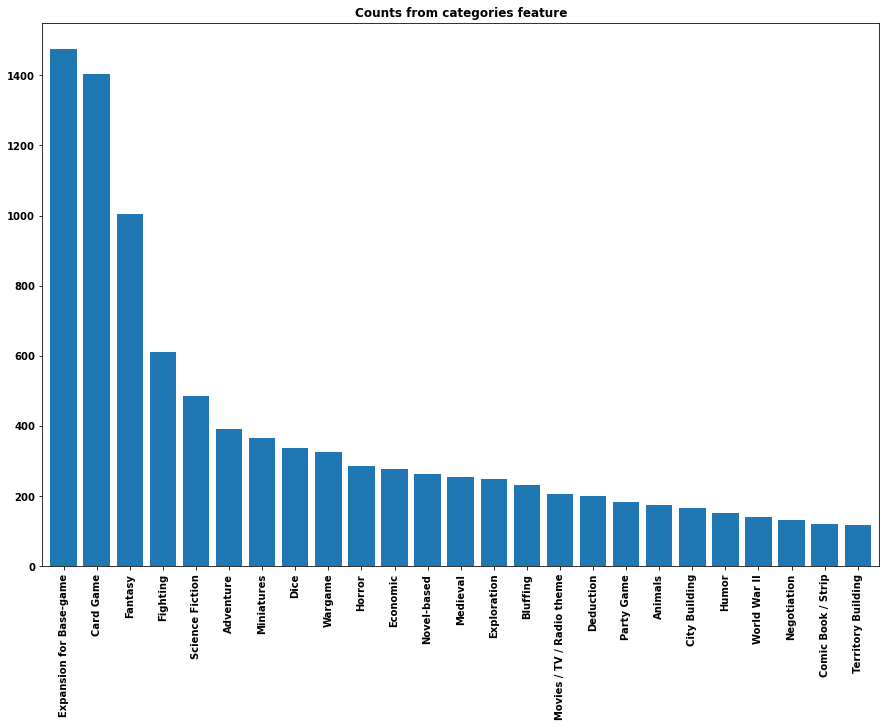

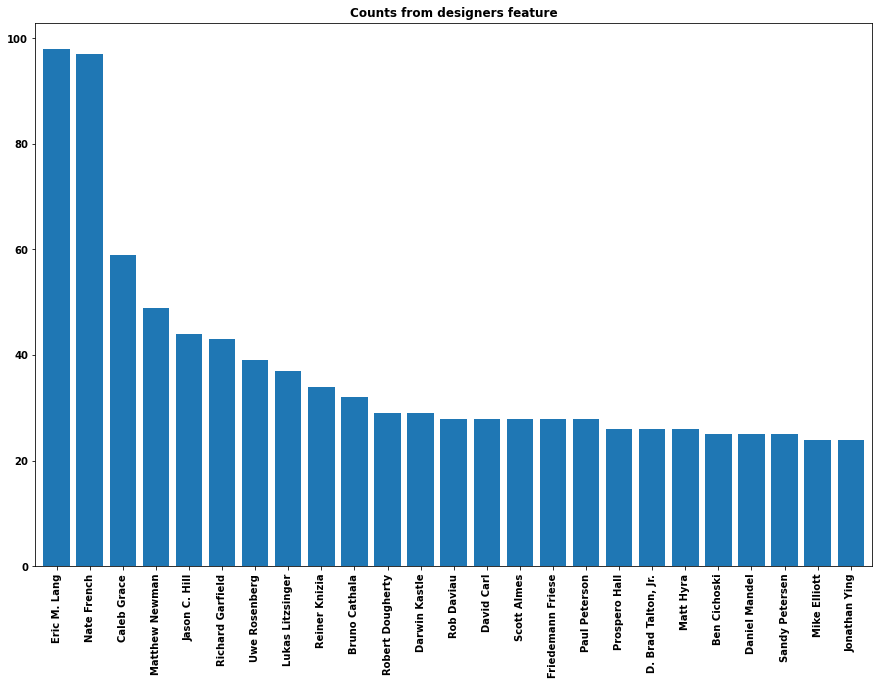

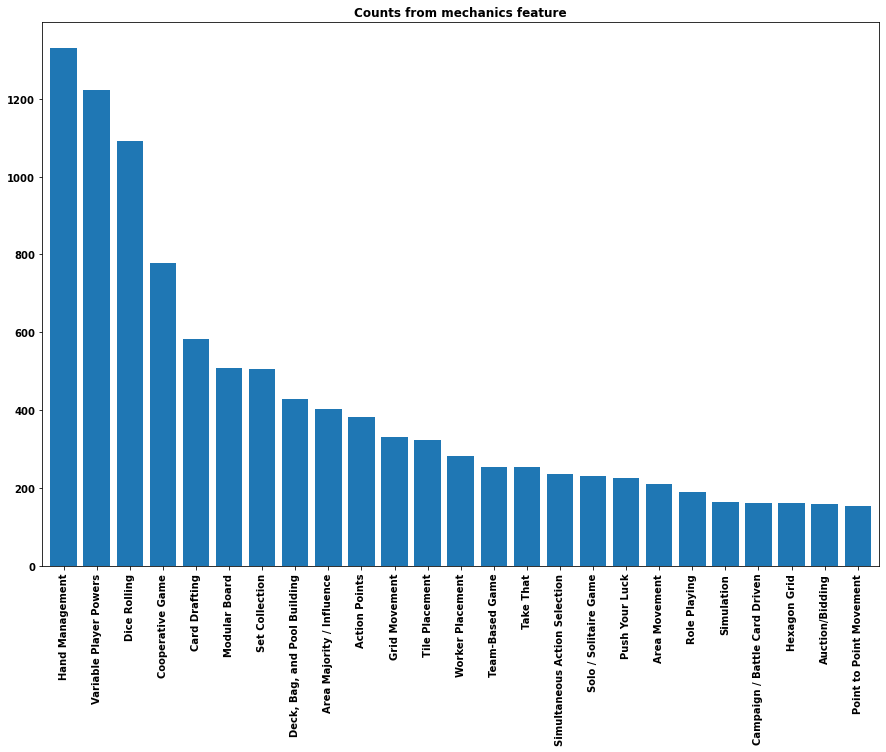

In [13]:
def plot_feature_with_list(df, feature, top_n_features, return_counts=False):
    feat = df[feature]

    #Get counts of games in each category
    counts = Counter(x for xs in feat for x in set(xs))
  
    if top_n_features>len(df):
        top_n_features=len(df)
    
    counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:top_n_features]
    counts_x, counts_y = zip(*counts)

    #Plot counts by category
    fig = plt.figure(figsize=(15, 10))
    plt.title('Counts from {} feature'.format(feature))
    plt.xticks(rotation=90)#, ha='right')
    plt.margins(x=0.01)
    plt.bar(counts_x, counts_y)
    
    if return_counts==True:
        return counts, plt.show()
    else:
        return plt.show()

cat_count_1, x = plot_feature_with_list(bgg_df, 'categories', top_n_features=25, return_counts=True)
design_count_1, x = plot_feature_with_list(bgg_df, 'designers', top_n_features=25, return_counts=True)
mech_count_1, x = plot_feature_with_list(bgg_df, 'mechanics', top_n_features=25, return_counts=True)

We see that games with the `Expansion for Base-game` category is the largest by count.  Since some games have an inordinate number of expansion.  Naturally, if a base-game falls into certain categories (e.g. "Adventure"), then it's safe to assume (for now) that its expansions will more likely have those same categories, thus inflating the count.  So, for now, lets remove games with the `Expansion for Base-game` category from the dataset so we can focus in on core games.

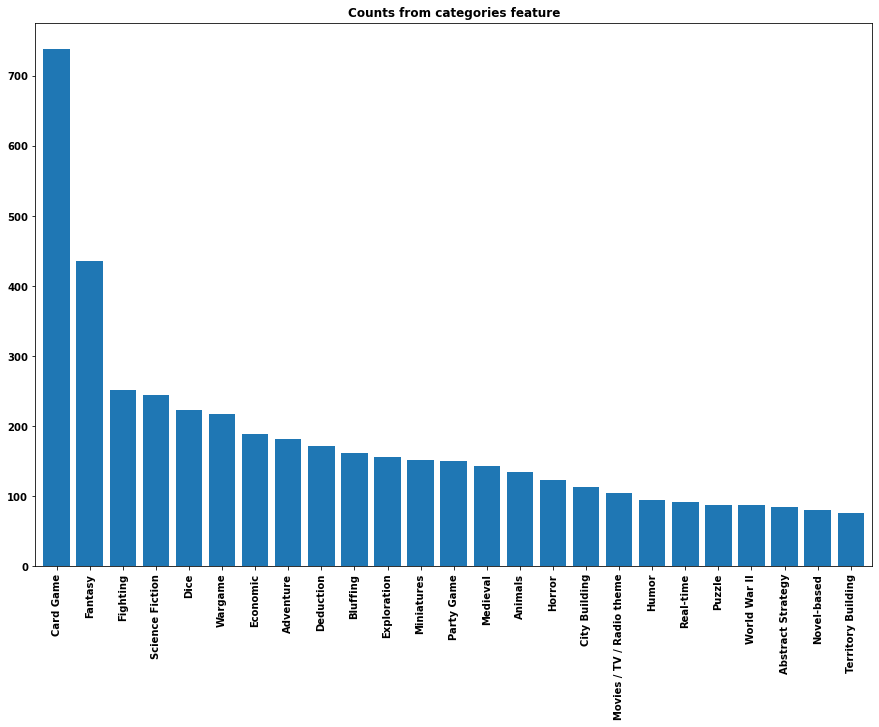

In [14]:
#Removing games containing the category label 'Expansion for Base-game'
bgg_no_expansions = bgg_df[bgg_df['categories'].apply(lambda x: 'Expansion for Base-game' not in x)]
cat_count_2, x =  plot_feature_with_list(bgg_no_expansions, 'categories', top_n_features=25, return_counts=True)

In [17]:
#Get percentage change between two categories ('card games', and 'fantasy')
print('There is a {:.2f}% change between the top two categories ("Card Game", "Fantasy").'.format((cat_count_2[0][1] - cat_count_2[1][1])/cat_count_2[0][1]*100))

There is a 41.00% change between the top two categories ("Card Game", "Fantasy").


With such a large difference between the top two categories, lets remove card games, as well.

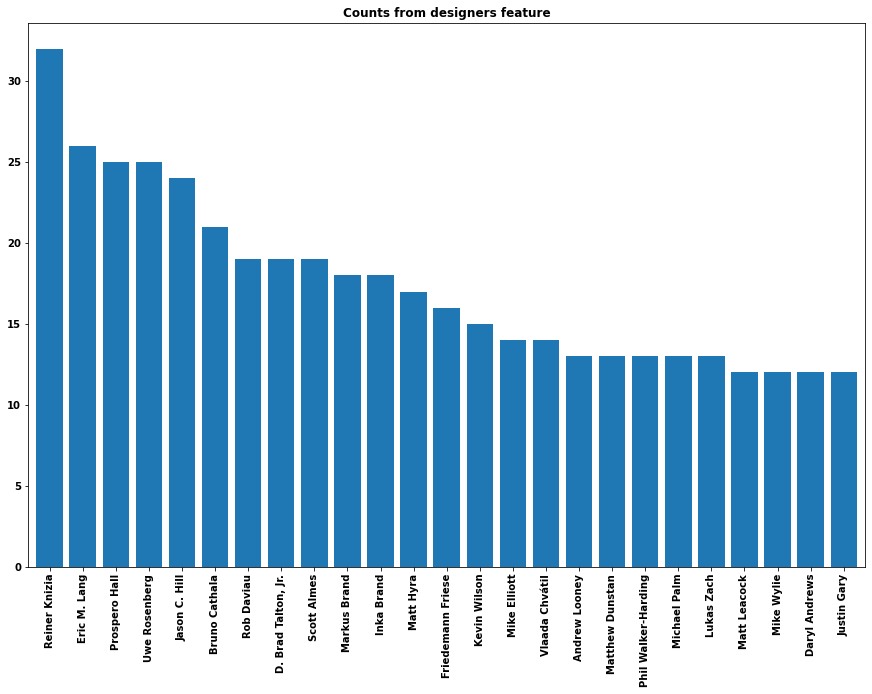

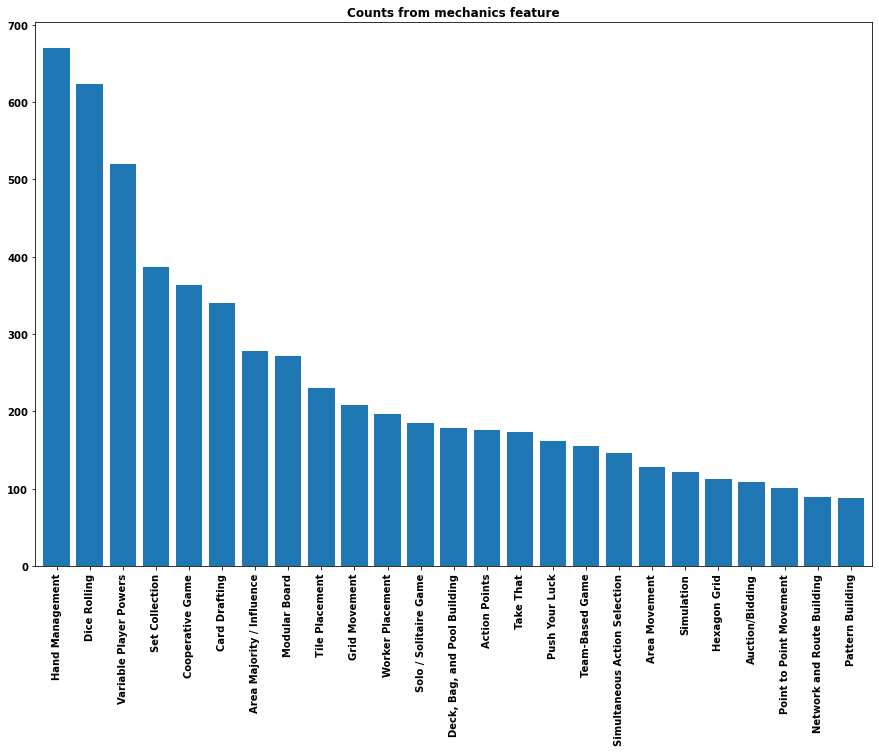

In [16]:
#Taking a look at the other features after having removed game expansions
design_count_2, x = plot_feature_with_list(bgg_no_expansions, 'designers', top_n_features=25, return_counts=True)
mech_count_2, x = plot_feature_with_list(bgg_no_expansions, 'mechanics', top_n_features=25, return_counts=True)

With an increase of more than 40% of games falling into the 'card game' category, we can reasonably expect the 'hand management' mechanic to come out on top.  The top three designers have an extensive "hand" in the development of LCGs (living card games), which also aligns with the previous two insights.

What happens though, if we eliminate games from our dataset that fall into the category "card games"?

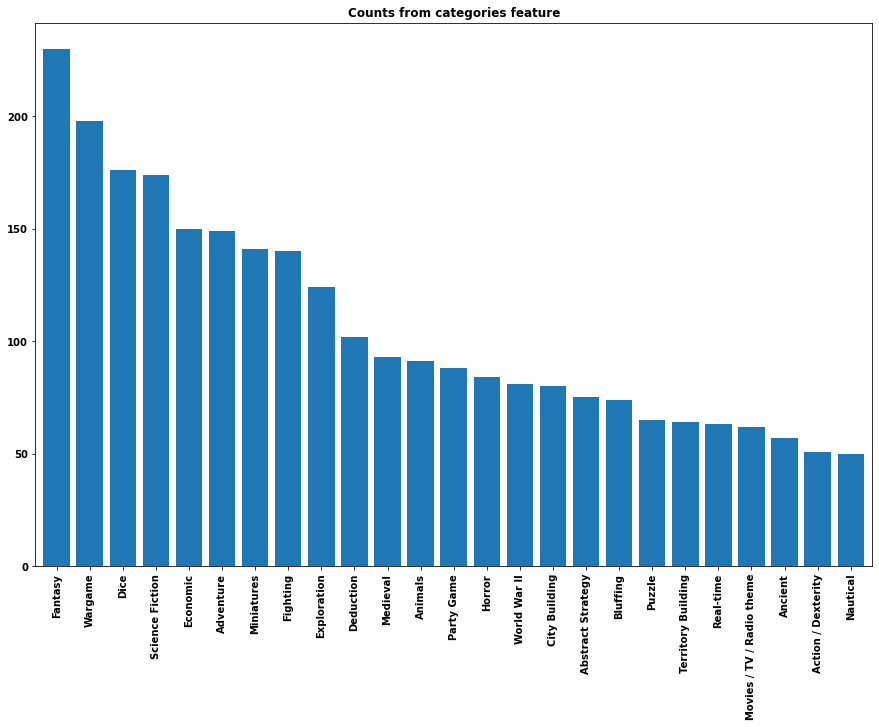

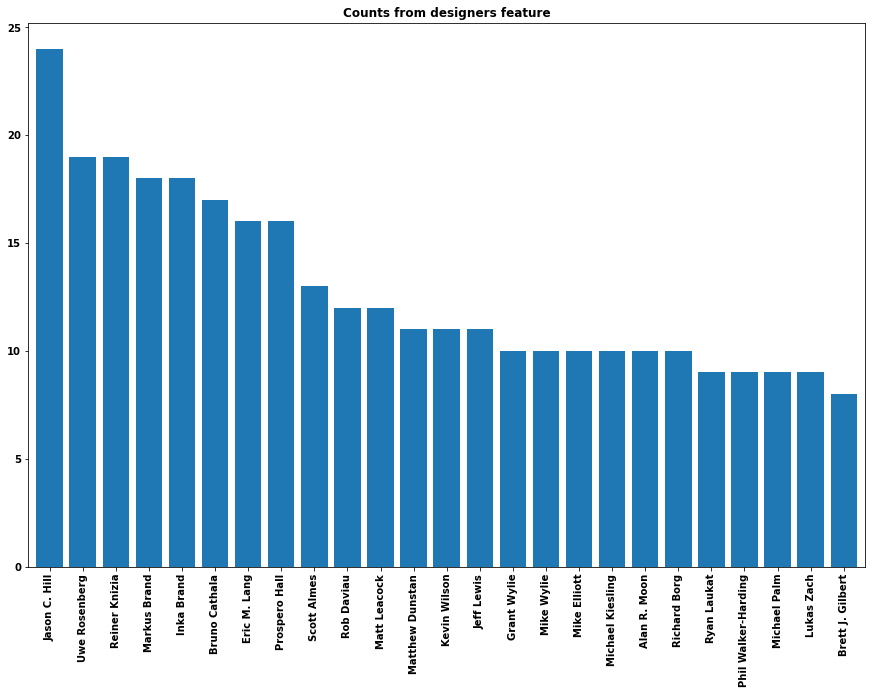

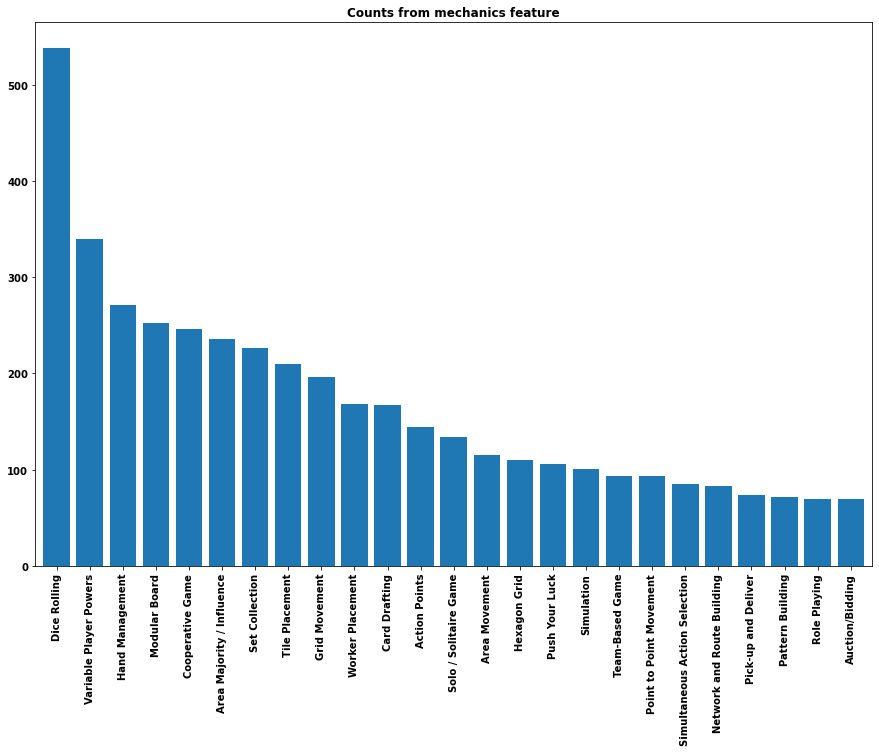

In [18]:
#Removing games containing the category label 'Card Game' and replotting
bgg_no_CGs = bgg_no_expansions[bgg_no_expansions['categories'].apply(lambda x: 'Card Game' not in x)]
#Plot
cat_count_3, x = plot_feature_with_list(bgg_no_CGs, 'categories', top_n_features=25, return_counts=True)
design_count_3, x = plot_feature_with_list(bgg_no_CGs, 'designers', top_n_features=25, return_counts=True)
mech_count_3, x = plot_feature_with_list(bgg_no_CGs, 'mechanics', top_n_features=25, return_counts=True)

Let's take a look at the actual values behind these plots.  Particularly, lets see how the rankings of each category change as we removed the `Expansion for Base-game` and `Card Game` categories.

In [19]:
from collections import defaultdict

def get_val_from_tupled_list(tupled_list):
    d = defaultdict(list)
    for a, b in tupled_list:
        d[a].append(b)
    return d

In [20]:
#Get counts from each tuple to build rankings dataframe
#Categories Dataframe
cat_df = pd.DataFrame(data=[get_val_from_tupled_list(cat_count_1).keys(), 
                            get_val_from_tupled_list(cat_count_2).keys(), 
                            get_val_from_tupled_list(cat_count_3).keys()]).T
cat_df = cat_df.rename(columns={0:'all', 1:'removed_expansions', 2:'removed_card_games'})

In [21]:
#Get index changes between columns 1 ('all') and 2 ('removed_expansions')
def get_rank_chg(df, col_1, col_2):
    rank_dict = {}
    for i in df[col_1]:

        x = df[df[col_2]==i].index.values
        rank_dict[i] = x

    #Clean up dict
    for cat, rank in rank_dict.items():
        if not len(rank):
            rank_dict[cat] = None
        else:
            rank_dict[cat] = rank[0]

    #Get change in rank
    rankings = []
    for rank, idx in zip(rank_dict.values(), df.index.values):
        if rank:
            rankings.append(idx - rank)
        elif rank in df[col_2]:
            rankings.append(0-rank)
        else:
            rankings.append(None)

    new_col_name = '_'.join(('rankings_chg', col_1, col_2))
    df[new_col_name] = rankings
    return df

get_rank_chg(cat_df, 'all', 'removed_expansions')
get_rank_chg(cat_df, 'removed_expansions', 'removed_card_games')

,all,removed_expansions,removed_card_games,rankings_chg_all_removed_expansions,rankings_chg_removed_expansions_removed_card_games
0,Expansion for Base-game,Card Game,Fantasy,NaN,NaN
1,Card Game,Fantasy,Wargame,0.0,0.0
2,Fantasy,Fighting,Dice,1.0,-5.0
3,Fighting,Science Fiction,Science Fiction,1.0,0.0
4,Science Fiction,Dice,Economic,1.0,2.0
5,Adventure,Wargame,Adventure,-2.0,4.0
6,Miniatures,Economic,Miniatures,-5.0,2.0
7,Dice,Adventure,Fighting,3.0,2.0
8,Wargame,Deduction,Exploration,3.0,-1.0
9,Horror,Bluffing,Deduction,-6.0,-8.0


__Conclusions:__
When removing expansions, big changes occurred in the following categories (with the change direction and magnitude being notated in parentheses):
* Miniatures (-5)
* Horror (-6)
* Deduction (-8)    
* Novel-based (-12)
* Bluffing (+5)
* Party Game (+5)

This informs us broadly of categories composition.  That, games identified as expansions more often affiliate with the categories experiencing a negative change than those that experienced a positive change in their ranking.  Conversely, it's also true that "Bluffing" and "Party" games, with a few exceptions, do not have many expansions.

When removing card games (after removing expansions), big changes occurred in the following categories (with the change direction and magnitude being notated in parentheses):
* Fighting (-5)
* Bluffing (-8)
* Miniatures (+5)
* Territory Building (+5)    
* Abstract Strategy (+6)    
* World War II (+7)

Additionally, we can determine here than many "Card Games" typically do not also fall into the "Miniatures", "Territory Building", "Abstract Strategy", or "World War II" categories.  They do, however, more often than included among the "Fighting" and "Bluffing" categories.


### __Exploring Outlier, Correlations, and Distributions__

Next we'll take a look at the outliers, correlation, and distributions among various features of the dataset.  This is critical to the data exploration phase so as to understand the dataset.  From this, we'll learn which algorithms may perform best when we implementing our predictive model.

First though, a bit of prep work is needed.  To make things easy, we'll binarize our 

In [22]:
#Binarize the following categories:
abbreviations = {'categories': 'cat',
                 'designers': 'design',
                 'mechanics': 'mech',
                 'is_expansion': 'is_exp',}

df_cat = pd.get_dummies(bgg_df['categories'].apply(pd.Series).stack(), prefix=abbreviations['categories'], drop_first=True).sum(level=0)
df_design = pd.get_dummies(bgg_df['designers'].apply(pd.Series).stack(), prefix=abbreviations['designers'], drop_first=True).sum(level=0)
df_mech = pd.get_dummies(bgg_df['mechanics'].apply(pd.Series).stack(), prefix=abbreviations['mechanics'], drop_first=True).sum(level=0)
df_is_exp = pd.get_dummies(bgg_df['is_expansion'].apply(pd.Series).stack(), prefix=abbreviations['is_expansion'], drop_first=True).sum(level=0)


In [23]:
bgg_all = bgg_df.join(df_cat)
bgg_all = bgg_all.join(df_design)
bgg_all = bgg_all.join(df_mech)
bgg_all.drop(columns=['categories', 'designers', 'mechanics', 'is_expansion'], inplace=True)
bgg_all = bgg_all.fillna(0)
bgg_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3714 entries, 302809 to 274442
Columns: 1982 entries, min_players to mech_Zone of Control
dtypes: float64(1970), int64(12)
memory usage: 56.3 MB


In [24]:
#Check data types to make sure they're all numeric
for col in bgg_all.columns:
    if bgg_all[col].dtype != np.number:
        print(col, ': ', type(bgg_all[col].iloc[0]))

min_players :  <class 'numpy.int64'>
max_players :  <class 'numpy.int64'>
min_age :  <class 'numpy.int64'>
playing_time :  <class 'numpy.int64'>
users_commented :  <class 'numpy.int64'>
users_owned :  <class 'numpy.int64'>
users_rated :  <class 'numpy.int64'>
users_trading :  <class 'numpy.int64'>
users_wanting :  <class 'numpy.int64'>
users_wishing :  <class 'numpy.int64'>
yrs_on_mkt :  <class 'numpy.int64'>
expansion_count :  <class 'numpy.int64'>


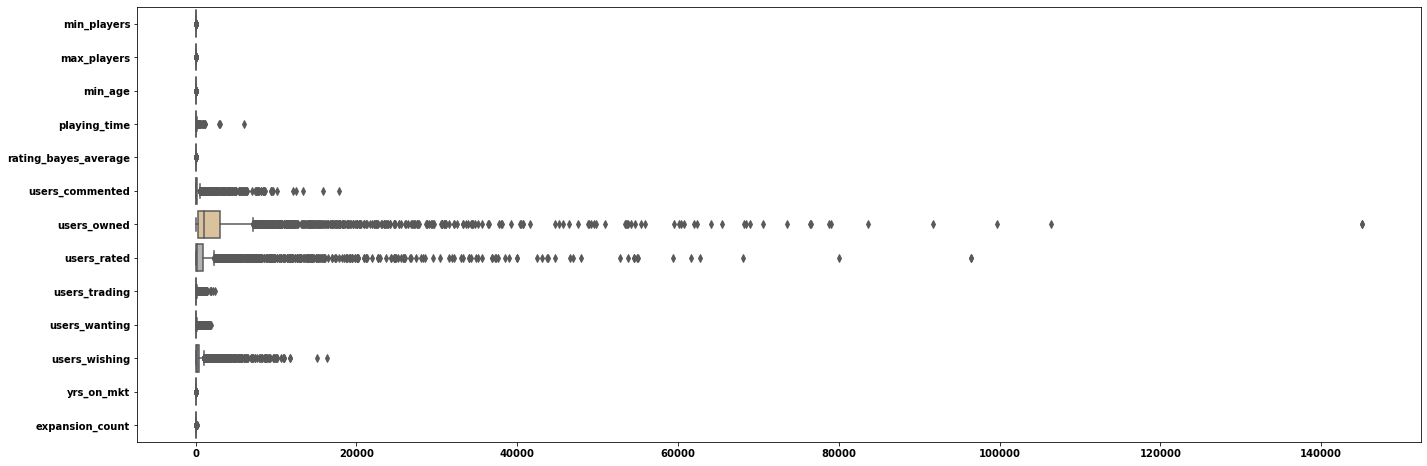

In [26]:
#Checking for Outliers
cols = 13
temp = bgg_all.iloc[:,:cols]
first_n_cols = temp.columns
fig= plt.figure(figsize=(23, 8))
ax = sns.boxplot(data=temp, orient='h', palette='Set2')

Plenty of outliers in the `users_*` categories!  For the time being, we'll drop those features, see how the model does, and maybe come back to them at a future date.  That way, we'll be able to get an minimum viable product up and running more quickly.

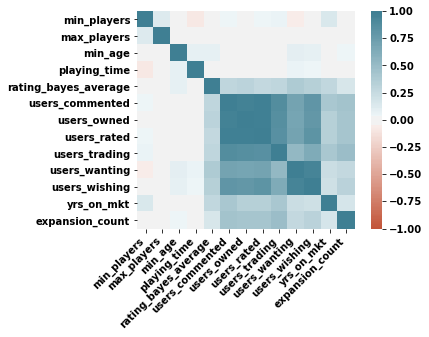

users_owned             1.000000
users_rated             0.979463
users_commented         0.961715
users_trading           0.859716
users_wishing           0.795317
users_wanting           0.680590
expansion_count         0.433516
yrs_on_mkt              0.344536
rating_bayes_average    0.316946
min_players             0.029954
min_age                 0.026304
max_players             0.024325
playing_time           -0.004047
Name: users_owned, dtype: float64


In [33]:
#Develop correlation matrix
corr_matrix = temp.corr()
ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
#List of correlation values for a single column
plt.show()
print(corr_matrix['users_owned'].sort_values(ascending=False))

This is about what I expected.  The `users_*` categories are largely correlated (which makes sense, as a user that owns a game, is more likely to rate it, and also more likely to trade a game - as opposed to someone that never owned it in the first place); a bit of confirmation of common sense.  We'd also expect that the longer a game is on the market (>`yrs_on_mkt`), the more reviews, ratings, owners, wishers, etc. it may have.

It is interesting that there is such low correlation between `yrs_on_mkt` and `expansion_count`, as I would have thought that a game that's been on the market longer would have more expansions published.  It would warrant further investigation, but my next hypothesis would be that many games have a short lifecycle these days (maybe 1-2 years), and therefore all expansions come out during that period (or sooner).  As we learned above, there aren't many outliers in `yrs_on_mkt` to skew that correlation though.

While the correlation is weak, it's also interesting that the `rating_bayes_average` variable is most strongly correlated to `users_wanting` variable.  However, the correlation may be insigificantly weak.

The fact that `users_wishing` and `users_wanting` is so strongly correlated, may indicate that the two are redundant (as their definitions are similar).  Further investigation into definition, distribution, etc. is warranted.

### __Examining Data Distribution__

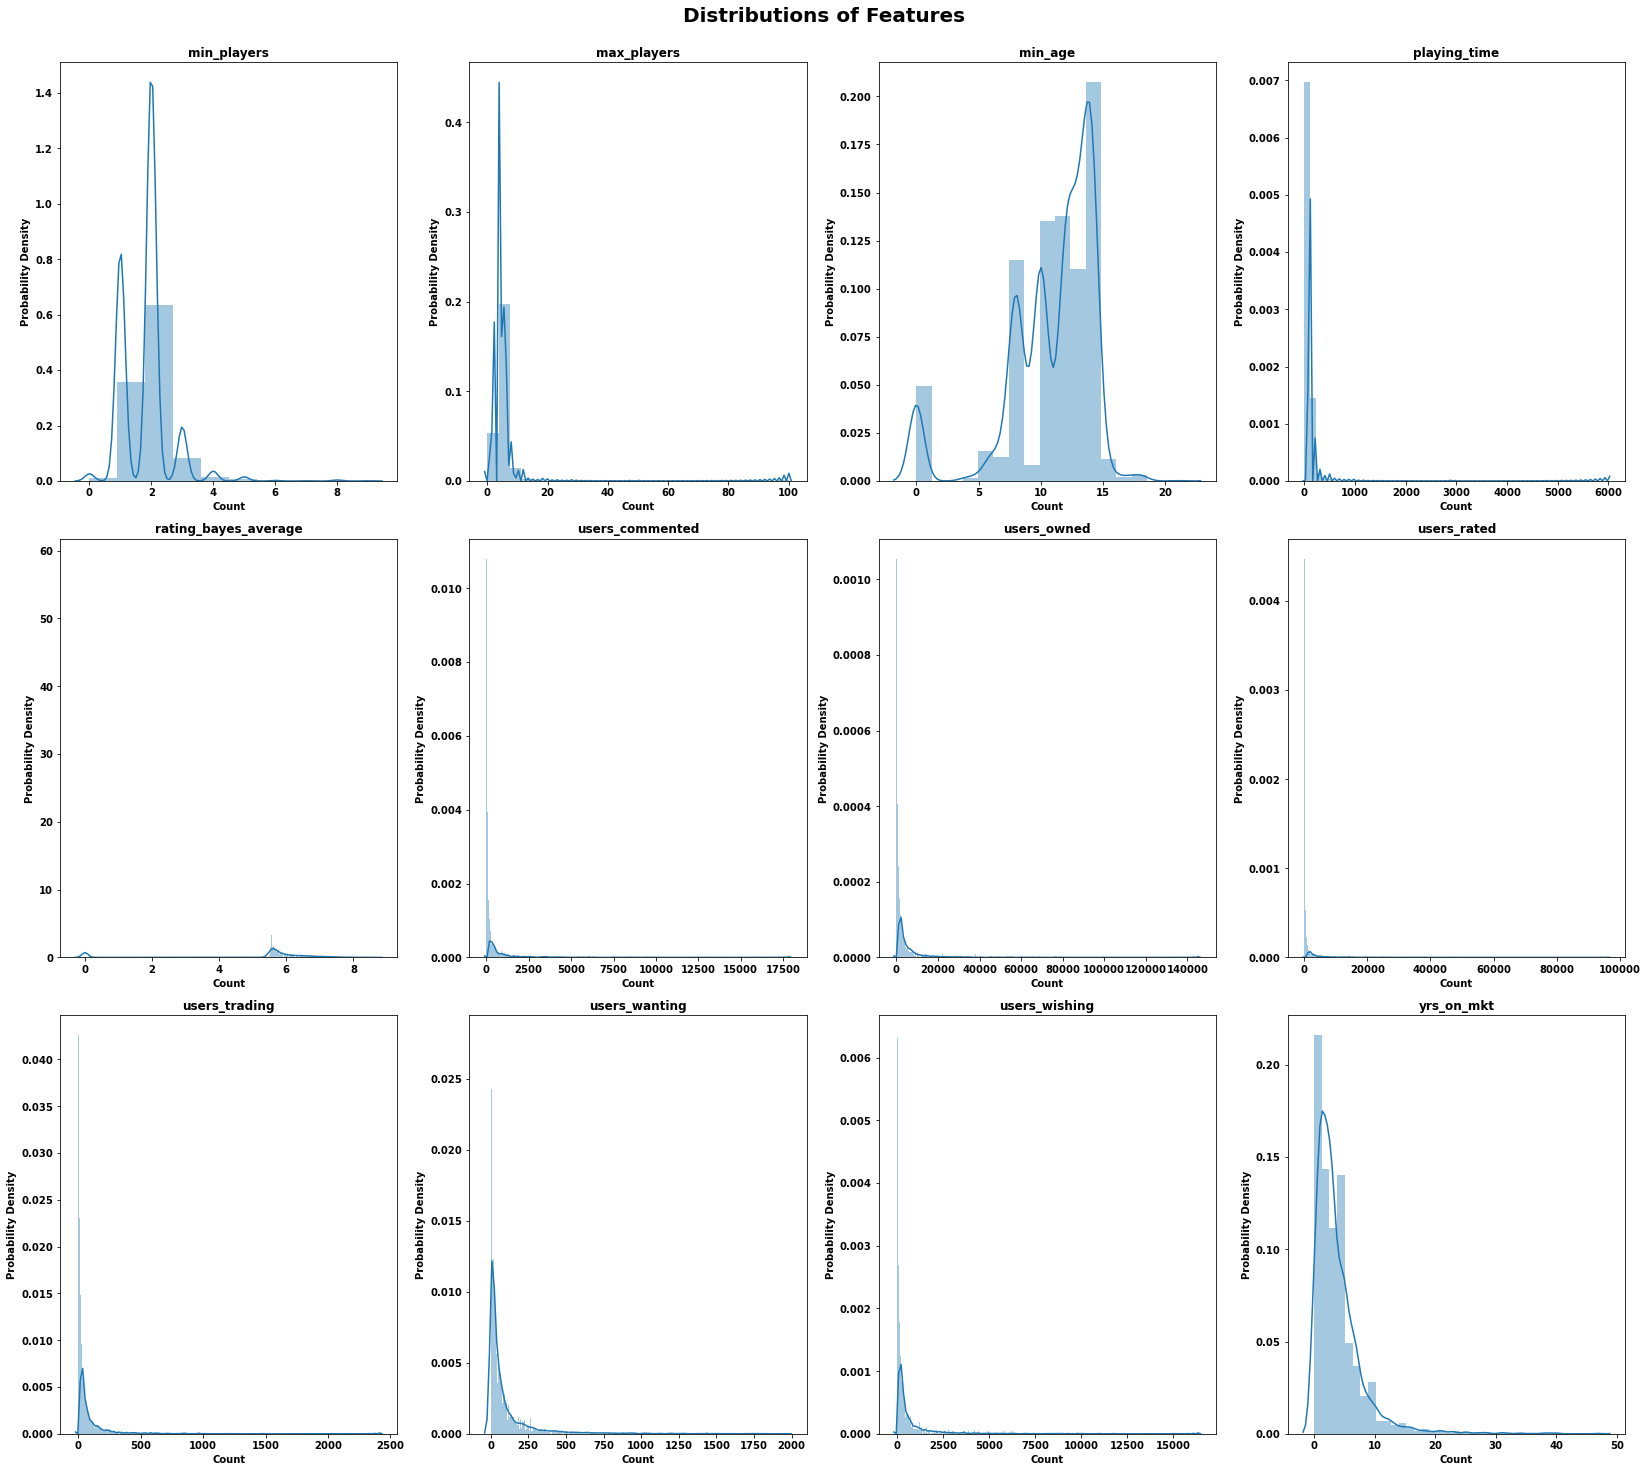

In [34]:
#Visual check of data distribution

def plot_distributions(df, n_cols, subplot_rows=3, subplot_cols=4):
    data = df.iloc[:,:n_cols] #get first n columns of data
    fig, axes = plt.subplots(nrows=subplot_rows, ncols=subplot_cols, figsize=(23, 20))
    fig.suptitle('Distributions of Features', size=20, y=1.02)

    for i, ax in enumerate(axes.flatten()):
        sns.distplot(df.iloc[:,i], kde=True, ax=ax, bins=len(np.unique(df.iloc[:,i])))
        ax.set_title(df.columns[i])
        ax.set_xlabel('Count')
        ax.set_ylabel('Probability Density')

    fig.tight_layout()
    plt.show()
    
plot_distributions(bgg_all, n_cols=12, subplot_rows=3, subplot_cols=4)

As we can see, the data distribution for most features is not normal, and skews heavily to the left.  For most, this is due to the large outliers in each feature.  We'll take a closer look at these distributions, the skew, and what we can do to fix it.

### __Examining Skew, Kurtosis, and the Effects of Transformers__

In [35]:
#Describe the current distributions
def calc_skew_kurtosis_normaltest(df, n_cols=None, col_name=None):
    if n_cols:
        cols = list(df.iloc[:,:n_cols].columns)
    elif col_name:
        cols = list(col_name)
    else:
        cols=list(df.columns)
        
    #Calculating skew & kurtosis
    skew_kurtosis = {}
    for col in cols:
        d_temp = {}
        #Calculate skew
        d_temp['skew'] = round((stats.skew(df[col])), ndigits=3)

        #Interpret skew
        if -0.5 < d_temp['skew'] < 0.5: #approx. symmetric
            d_temp['skew_interp'] = 'approx. symmetric'
        elif  -0.5 < d_temp['skew'] < -1.0 or 0.5 < d_temp['skew'] < 1.0: #moderately skewed
            d_temp['skew_interp'] = 'moderately skewed'
        else: #highly skewed
            d_temp['skew_interp'] = 'highly skewed'

        #Calculate kurtosis
        d_temp['kurtosis'] = round((stats.kurtosis(df[col])), ndigits=3)

        #Interpret kurtosis
        if  -0.5 <  d_temp['kurtosis'] < 0.5:
            d_temp['kurtosis_interp'] = 'approx. normal dist. (mesokurtic)'
        elif  d_temp['kurtosis'] <= -0.5: 
            d_temp['kurtosis_interp'] = 'light-tailed (negative) (platykurtic)'
        elif  d_temp['kurtosis'] >= 0.5:
            d_temp['kurtosis_interp'] = 'light-tailed (positive) (leptokurtic)'

        #Test normality of distribution
        stat, p = stats.normaltest(df[col])
        d_temp['stat'] = stat
        d_temp['p_val'] = p
        alpha = 0.05
        if p > alpha:
            d_temp['norm_interp'] = 'appears Gaussian (fail to reject H0)'
        else:
            d_temp['norm_interp'] = 'not Gaussian (reject H0)'

        skew_kurtosis[col] = d_temp  
        
    return pd.DataFrame(skew_kurtosis).T

#Run function
calc_skew_kurtosis_normaltest(bgg_all)

,skew,skew_interp,kurtosis,kurtosis_interp,stat,p_val,norm_interp
min_players,1.751,highly skewed,10.364,light-tailed (positive) (leptokurtic),1613.02,0,not Gaussian (reject H0)
max_players,11.607,highly skewed,147.029,light-tailed (positive) (leptokurtic),6252.07,0,not Gaussian (reject H0)
min_age,-1.497,highly skewed,2.26,light-tailed (positive) (leptokurtic),975.851,1.24922e-212,not Gaussian (reject H0)
playing_time,26.746,highly skewed,1004.11,light-tailed (positive) (leptokurtic),9284.94,0,not Gaussian (reject H0)
rating_bayes_average,-1.583,highly skewed,0.926,light-tailed (positive) (leptokurtic),898.302,8.63167e-196,not Gaussian (reject H0)
...,...,...,...,...,...,...,...
mech_Voting,6.681,highly skewed,42.637,light-tailed (positive) (leptokurtic),4455.17,0,not Gaussian (reject H0)
mech_Worker Placement,3.202,highly skewed,8.252,light-tailed (positive) (leptokurtic),2376.97,0,not Gaussian (reject H0)
mech_Worker Placement with Dice Workers,13.874,highly skewed,190.479,light-tailed (positive) (leptokurtic),6830.97,0,not Gaussian (reject H0)
"mech_Worker Placement, Different Worker Types",13.517,highly skewed,180.705,light-tailed (positive) (leptokurtic),6741.13,0,not Gaussian (reject H0)


Running the `skew` and `kurtosis` tests from the statsmodels package, we're able to get some quantitative data to test our hypotheses.  Setting our p-value at 0.05, we can easily identify that, quantitatively, all of these datasets are not likely a Gaussian distribution.

We've clearly identified that the distribution of many features in the dataset are skewed with high kurtosis. So what can we do about it?  

After some research, I found [Scikit-learn's Power Transformer]('https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html').  The transformer applies parametric and monotonic transformations to make the data more Gaussian-like (normally distributed).  I chose to use the Yeo-Johnson transform as it supports negative numbers (whereas the Box-Cox transform requires a dataset of only positive numbers).  I believe that I could get the dataset into a positive-numbers only format, in the spirit of MVPs, we'll apply Yeo-Johnson and see where it takes us.  

In [36]:
#Apply Power Transformer
cols = list(bgg_all.columns)

test_df = bgg_all#.drop(columns=['categories', 'designers', 'mechanics'])

#Apply transformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)
skl_yeojohnson = pt.fit(test_df) #calculates the optimal lambdas for the included features
skl_yeojohnson = pt.transform(test_df) #applies optimal lambdas

df_xt = pd.DataFrame(data=skl_yeojohnson, columns=cols)

In [37]:
#Verify changes due to transformation
skew_kurtosis_normal_results = calc_skew_kurtosis_normaltest(df_xt)
skew_kurtosis_normal_results.head()

,skew,skew_interp,kurtosis,kurtosis_interp,stat,p_val,norm_interp
min_players,0.021,approx. symmetric,1.96,light-tailed (positive) (leptokurtic),171.469,5.83527e-38,not Gaussian (reject H0)
max_players,-0.174,approx. symmetric,6.826,light-tailed (positive) (leptokurtic),537.453,1.96552e-117,not Gaussian (reject H0)
min_age,-0.521,highly skewed,-0.127,approx. normal dist. (mesokurtic),152.763,6.73035e-34,not Gaussian (reject H0)
playing_time,0.384,approx. symmetric,7.184,light-tailed (positive) (leptokurtic),622.575,6.44979e-136,not Gaussian (reject H0)
rating_bayes_average,-0.971,highly skewed,0.426,approx. normal dist. (mesokurtic),442.506,8.14635e-97,not Gaussian (reject H0)


In implementing a the Power Transformer, I was able to remedy some of the skew/kurtosis problem, but not all of it (see new distributions below).  With skew still a problem, typical regressions will have a hard time with the data.  Consequently, I'll be using a random forest to model the data.  Decision trees, unlike linear methods, make no assumptions aobut the distribution of the dataset, and therefore shouldn't be affected by the remaining skewed distributions and problems with kurtosis. While no assumption is made, it seems that many people still believe that the Power Transformer can improve the predictive power of a random forest.

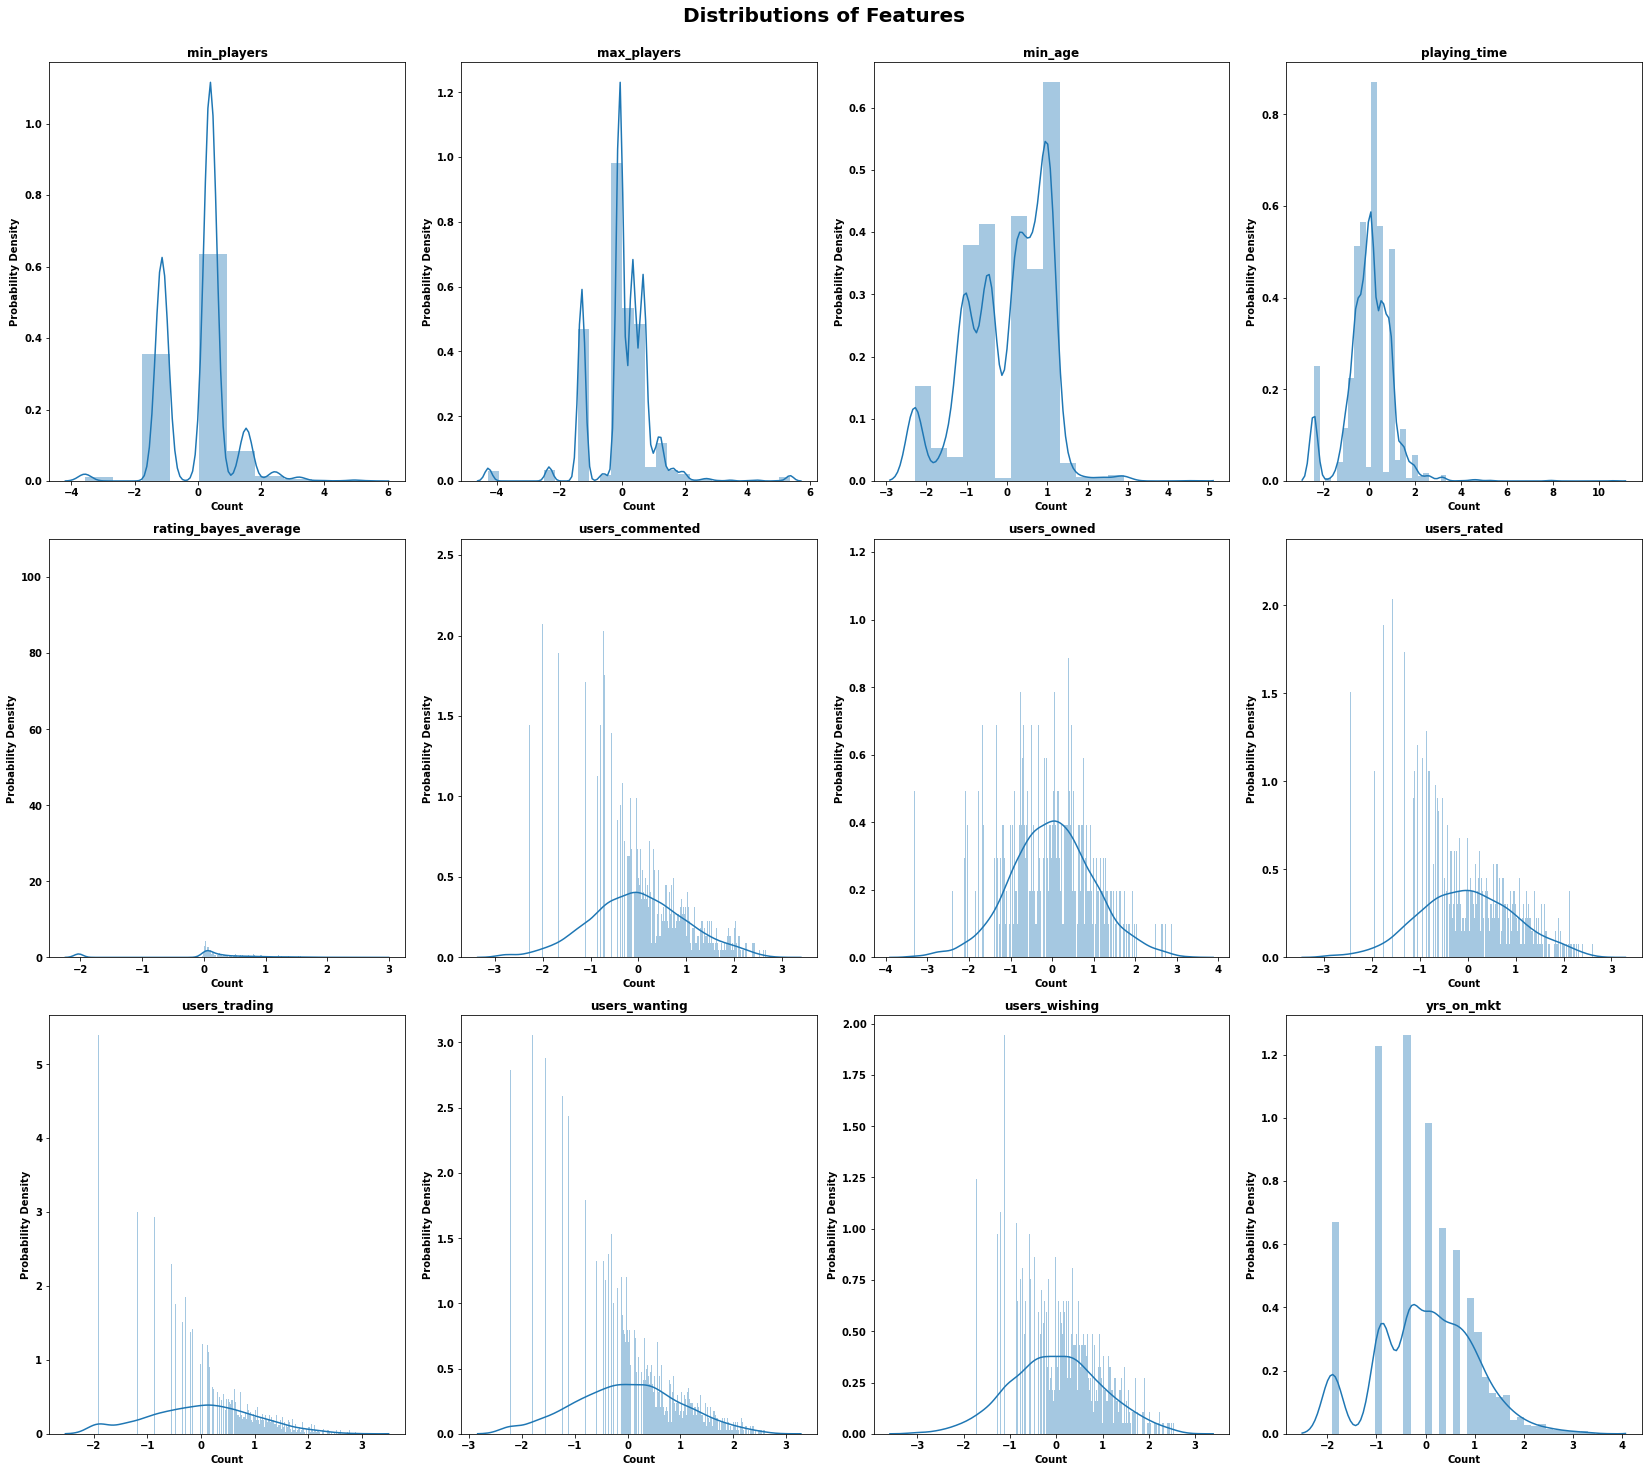

In [38]:
plot_distributions(df_xt, n_cols=12, subplot_rows=3, subplot_cols=4)

A couple of points to emphasize: 
1) Many of the features are clearly more normally distributed (though some admittedly have not improved desireably).  
2) Because the variables have been transformed, the interpretability of the values themselves within each feature is reduced.

## **Model with Pipeline**

I've found that the reduction in skew and stabilization of variance derived from the Power Transformer is helpful to the Random Forest Regression, and therefore I've decided to leave this transformer in the pipeline.

The pipeline is a demonstration of how the model could be initially productionized.  More work is required in dockerizing the model, pushing it to the cloud, and publishing it on a website.  

In [44]:
#Create custom transformer
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

In [45]:
y = bgg_df['rating_bayes_average']
X = bgg_df.drop(columns='rating_bayes_average')

#Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1,
                                                    random_state=123,
                                                    shuffle=True)

In [46]:
#Create numerical features & pipeline
num_pipe = Pipeline(steps=[('scaler', PowerTransformer(method='yeo-johnson', standardize=True))])

#Create categorical features & pipeline
cat_pipe = Pipeline(steps=[('mlb', MultiHotEncoder())
                          ])
#Create boolean features & pipeline (necessary?)
bool_pipe = Pipeline(steps=[('ordinal_enc', OrdinalEncoder())])

#Create 
preprocessor = ColumnTransformer(transformers=[
                                               ('num', num_pipe, make_column_selector(dtype_include=np.number)),
                                               ('cat', cat_pipe, make_column_selector(dtype_include='object')),
                                               ('bool', bool_pipe, make_column_selector(dtype_include='bool'))
                                               
                                              ])

reg_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('random_forest', RandomForestRegressor(n_estimators=1, n_jobs=-1))
#                            ('ridge_regressor', Ridge())
                          ])

reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   PowerTransformer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E67241B9A0>),
                                                 ('cat',
                                                  Pipeline(steps=[('mlb',
                                                                   MultiHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E602336160>),
                                                 ('bool',
                                                  Pipeline(steps=[('ordinal_enc',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E602336A00>)])),
                ('random_forest',
                 RandomForestRegressor(n_estimators=1, n_jobs=-1))])

In [47]:
#Testing the Mean-squared Error (MSE)
mse_train = mean_squared_error(y_train, reg_pipe.predict(X_train))
mse_test = mean_squared_error(y_test, reg_pipe.predict(X_test))

print("RF with full trees, Train MSE: {} Test MSE: {}".format(mse_train, mse_test))

RF with full trees, Train MSE: 0.008995194531597845 Test MSE: 0.026160755242204296


C:\Users\Lofgran\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['Adam Bain', 'Adam Chunn', 'Adam Hill', 'Alex Rockwell', 'Alexandre Emerit', 'Alvydas Jakeliunas', 'Andrew Zimmermann', 'Anthony Howgego', 'Aza Chen', 'Benjamin Walker', 'Bill Slavicsek', 'Brandon Beran', 'Brian Burgoyne', 'Brian David-Marshall', 'Brian M. Kibler', 'Carey Grayson', 'Charlie Bink', 'Clayton Hargrave', 'Colleen Skadl', 'Dan Halstad', 'Darryl Loyd', 'David Somerville', 'Dekan Wheeler', 'DigiSprite', 'Dominika Gerasimiak', 'Eric Jome', 'Federico Pierlorenzi', 'G. W. "Jerry" D\'Arcey', 'Gary Dicken', 'Gary Kagan', 'Geoff Bottone', 'Grant Lyon', 'Gwenaël Bouquin', 'Günter Burkhardt', 'Harold Mikolaitis', 'Ian VanNest', 'Jacques David', 'Jaime Miller', 'Jan Kirschner', 'Jason Thompson', 'Jody Boginski-Barbessi', 'Johan Benvenuto', 'John Fiorillo', 'John Wick', 'Jon Merchant', 'Jon Perry', 'Justyna Leszczyńska', 'Kalle Krenzer', 'Kare Jantunen', 'Karen Boginski', '

The error above comes from the model not having seen these game designers before (they were not in the model's training dataset).  This isn't a particular problem, and requires (at the moment), but in the future, I may add columns to the original training dataset for all game designers in the entire dataset (training and testing), without adding the actual, binarized data for those designers in the test set.  

There may also be another solution that I've not yet found in my research.

In training the model above, I'm implementing a cross-validated grid search to find the optimal parameters.

In [50]:
#Define Params
param_grid = {'random_forest__n_estimators': [10, 50, 100, 150, 200],
              'random_forest__min_samples_leaf': [2, 5, 10, 15, 20, 25, 30]}

#Run GridSearchCV
search = GridSearchCV(reg_pipe, param_grid, n_jobs=-1)#, refit=True)
search.fit(X_train, y_train)

#Report
print("Best parameter (CV score=%0.3f): " % search.best_score_)
print('--'*25)
print(search.best_params_)
print('--'*25)
# pd.DataFrame(search.cv_results_)

Best parameter (CV score=0.998): 
--------------------------------------------------
{'random_forest__min_samples_leaf': 2, 'random_forest__n_estimators': 150}
--------------------------------------------------


Now, we'll go ahead and run our test data through the new model and get our predictions.  I'll also plot the results because I'm interested in seeing if any heteroskedasticity exists in teh results.

C:\Users\Lofgran\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['Adam Bain', 'Adam Chunn', 'Adam Hill', 'Alex Rockwell', 'Alexandre Emerit', 'Alvydas Jakeliunas', 'Andrew Zimmermann', 'Anthony Howgego', 'Aza Chen', 'Benjamin Walker', 'Bill Slavicsek', 'Brandon Beran', 'Brian Burgoyne', 'Brian David-Marshall', 'Brian M. Kibler', 'Carey Grayson', 'Charlie Bink', 'Clayton Hargrave', 'Colleen Skadl', 'Dan Halstad', 'Darryl Loyd', 'David Somerville', 'Dekan Wheeler', 'DigiSprite', 'Dominika Gerasimiak', 'Eric Jome', 'Federico Pierlorenzi', 'G. W. "Jerry" D\'Arcey', 'Gary Dicken', 'Gary Kagan', 'Geoff Bottone', 'Grant Lyon', 'Gwenaël Bouquin', 'Günter Burkhardt', 'Harold Mikolaitis', 'Ian VanNest', 'Jacques David', 'Jaime Miller', 'Jan Kirschner', 'Jason Thompson', 'Jody Boginski-Barbessi', 'Johan Benvenuto', 'John Fiorillo', 'John Wick', 'Jon Merchant', 'Jon Perry', 'Justyna Leszczyńska', 'Kalle Krenzer', 'Kare Jantunen', 'Karen Boginski', '

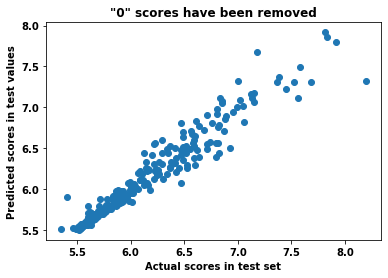

In [51]:
predictions = search.predict(X_test)

#Remove zeros
predictions_no_zeros = np.array([pred for pred in predictions if pred>0])
y_temp = np.array([pred for pred in y_test if pred>0])

#Define the plot
plt.title('"0" scores have been removed')
plt.xlabel('Actual scores in test set')
plt.ylabel('Predicted scores in test values')
plt.scatter(x=y_temp, y=predictions_no_zeros)
plt.show()

### __Testing for Homoskedasticity__

While the heterokedasticity in the results seems apparent, I want to run a few more tests (Breush-pagan, and White tests) to get a quantitative measure of homoskedasticity of the predictions.

In [52]:
resids = (predictions - np.array(y_test, dtype='float'))
X_test_temp = X_test.drop(columns=['mechanics', 'designers', 'categories'])
X_test_temp = pd.get_dummies(data = X_test_temp, columns=['is_expansion'], drop_first=True)

#Setup exogenous variable array
exog = np.array(X_test_temp.values, dtype='float')
exog = np.append(exog, np.ones(exog.shape), axis=1) #White test requires a 'constant' column

#The Breusch-Pagan test assumes that any heteroskedasticity is linear (which makes White test - which doesn't make that assumption - preferred in this case)
#Breusch-Pagan tests for the presence of heteroskedasticity while White tests for bias due to heteroskedasticity
#However, the BP test is more computationally efficient

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_test = het_breuschpagan(resids, exog)
white_test = het_white(resids, exog) #Better to get the white test running 

#The null hypothesis for this test is that the variances of the errors are equal (e.g. the dataset is homoskedastic) 
#With a p-value < 0.05, we reject the null hypothesis that the data are likely homoskedastic.
bp_het_results = dict(zip(labels, bp_test))
white_het_results = dict(zip(labels, white_test))

#Print results
pp = pprint.PrettyPrinter(indent=4)
print('Breusch-Pagan Test Results', '\n', '--'*20, '\n')
pp.pprint(bp_het_results)
print('\n','White Test Results', '\n', '--'*20, '\n')
pp.pprint(white_het_results)

Breusch-Pagan Test Results 
 ---------------------------------------- 

{   'F-Statistic': 12.755180174666737,
    'F-Test p-value': 4.655334411124752e-23,
    'LM Statistic': 117.75870393541662,
    'LM-Test p-value': 5.4907919434925074e-14}

 White Test Results 
 ---------------------------------------- 

{   'F-Statistic': 19.021863851342022,
    'F-Test p-value': 6.698010942588017e-81,
    'LM Statistic': 327.23811358414815,
    'LM-Test p-value': 3.6525101193112213e-25}


With a p-value of almost zero for both tests, we can reject the null hypothesis that the predictions are homoskedastic.  This is the same conclusion that I came to from the visual plot I created a couple cells back.  

For further reference, the effects of heteroskedasticity on decision trees can be found [here]('https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj6u8_Hoo3sAhW1PH0KHWnzC2IQFjABegQIAhAB&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1606.05273&usg=AOvVaw36CSz3Mn3NM1KYR0atZip7').  While the paper focuses on single decision trees, and not methods that aggregate decision trees, the conclusion of the paper is that the effects of heteroskedasticity on a decision tree is heavily dependent on the partitioning algorithm and pruning methods.  They do note however, that ensemble methods such as random forests may not be as sensitive (presumably due to their combining the results of many, many decision trees, instead of relying on a single tree).

Consequently, I believe that a random forest is the right algorithm to use on this particular dataset.